<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Técnicas de Inteligencia Artificial</header1></center>
<left><h1>Actividad 2. Trabajando con redes neuronales y Deep Learning</header1></left>

Presentado por: Ismael Pérez Nieves  <br>
Fecha: 09/01/2025

# Importación de librerias necesarias

# Parte I. Regresión

In [1]:
# Para esta actividad se importarán las siguientes librerías:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, OneHotEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop

C:\Users\Ismael Perez\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargar el Dataset

In [2]:
# Código para cargar el Dataset
df = pd.read_csv('./surv_variants.csv')
df

,Country,first_seq,num_seqs,last_seq,variant,censure_date,duration,censored,mortality_rate,total_cases,total_deaths,growth_rate
0,China,2019-10-22,3,2020-06-03,S.Q677,2020-06-21,225,True,0.052983,18259.460123,967.435583,16447.430706
1,USA,2020-03-03,26022,2021-11-19,S.Q677,2020-11-01,626,False,0.016111,256577.596234,4133.841031,84748.745876
2,Brazil,2020-03-09,1553,2021-11-12,S.Q677,2020-11-07,613,False,0.027846,101550.140466,2827.764288,42356.907426
3,Australia,2020-03-20,88,2021-11-14,S.Q677,2020-11-18,604,False,0.009905,1402.239579,13.889752,1227.122500
4,Sweden,2020-03-20,810,2021-11-19,S.Q677,2020-11-18,609,False,0.012711,1659.148728,21.089425,2521.042925
...,...,...,...,...,...,...,...,...,...,...,...,...
4108,Kazakhstan,2021-08-17,88,2021-08-19,21J.Delta,2022-04-17,2,True,0.014838,52244.958678,775.206612,7722.500000
4109,Cyprus,2021-08-28,1,2021-08-28,21J.Delta,2022-04-28,0,True,0.004407,487.565957,2.148936,NaN
4110,Guyana,2021-09-06,18,2021-09-08,21J.Delta,2022-05-07,2,True,0.024429,3855.168000,94.176000,131.000000
4111,Comoros,2021-10-05,11,2021-10-26,21J.Delta,2022-06-05,21,True,0.034727,1012.239130,35.152174,3.152456


## Descripción de la fuente del Dataset

Vamos a trabajar con un conjunto de datos que contiene un registro de los datos de las diferentes variantes de SARS-CoV-2 en cada país. Describe información como el número de casos, muertes, el crecimiento...

## Explique el problema a resolver. 

Queremos construir un modelo de aprendizaje automático en el que podamos hacer una predicción de cuántas muertes se van a producir en un país en función de la evolución del virus expresado por variables medibles que describen cómo afecta el virus a la población. Gracias a este modelo, podremos predecir el impacto que tendrá una variante de SARS-CoV-2 en el número de muertes al inicio del brote, así como identificar cuáles son los factores más determinantes para que los organismos competentes sepan dónde deben focalizar sus esfuerzos.

## Caracterización del Dataset

El conjunto de datos contiene un total de 12 columnas. En esta sección, solo vamos a describir las columnas que van a ser utilizadas en el ejercicio por motivos de simplicidad y claridad.

In [3]:
entry_columns = ['num_seqs', 'variant', 'duration', 'censored', 'total_cases', 'growth_rate'] # Variables de entrada
output_columns = ['total_deaths'] # Variables de salida
cleaned_columns = ['num_seqs', 'variant', 'duration', 'censored', 'total_cases', 'growth_rate', 'total_deaths'] # Variables utilizadas

df = df[cleaned_columns]

In [4]:
# Número de instancias en total
print("Número de instancias: " + str(len(df)))

Número de instancias: 4113


Las variables de entrada son:
- num_seqs -> Número de secuencias de la variante.
- variant -> Nombre de la variante de SARS-CoV-2.
- duration -> Duración de la epidemia expresada en días.
- censored -> Indica si la epidemia fue censurada o no.
- total_cases -> Número total de casos aproximado de la variante.
- growth_rate -> Tasa de crecimiento de la variante.

In [5]:
X = df[entry_columns] # Datos de entrada

# Número de variables de entrada
print("Número de variables de entrada: " + str(len(X.columns)))

# Tipo de las variables de entrada
print("Tipos de las variable de entrada:")
print(X.dtypes)

Número de variables de entrada: 6
Tipos de las variable de entrada:
num_seqs         int64
variant         object
duration         int64
censored          bool
total_cases    float64
growth_rate    float64
dtype: object


Tenemos una variable categórica, _variant_. Vamos a observar cuáles son los valores únicos de esta columna:

In [6]:
# Mostrar valores únicos de variant
print(f"Valores únicos para las variantes: {df['variant'].unique()}")

Valores únicos para las variantes: ['S.Q677' '20A.S.210T' 'S.N501' 'S.L18' 'S.Y453F' 'Omicron.Similar'
 '21A.Delta.S.K417' 'S.V1122L' 'S.Q677H.Robin2' 'S.A626S' 'S.Q677H.Heron'
 '21A.Delta' 'Delta.250I' 'S.Q613' 'S.Q677H.Robin1' 'S.Q677P.Pelican'
 '21I.Delta' '20H.Beta.V2' 'Delta.299I' 'Delta.N.412R' 'Delta.ORF1a3059F'
 '20B.S.732A' 'ORF1a.S3675' '21K.Omicron' '21D.Eta' '21F.Iota' 'S.D80Y'
 'S.Q677H.Quail' 'DanishCluster' '20A.S.126A' 'S.Q677H.Mockingbird'
 'S.K417' 'S.S98F' 'Delta.145H' 'S.Y145' 'S.Y144-' '21H.Mu' '21B.Kappa'
 'S.Q677H.Bluebird' '20I.Alpha.V1' 'S.A222' 'S.T572'
 'S.Q677H.Yellowhammer' '21C.Epsilon' '21A.21B' 'S.E484' '20A.EU2'
 'S.S477' 'S.H69-' 'S.Q677R.Roadrunner' '20J.Gamma.V3' 'S.N439K'
 '20B.S.796H' 'S.H655' '21G.Lambda' '20A.EU1' 'S.P681' '21J.Delta']


La variable de salida es:
- total_deaths -> Número total de muertes aproximado de la variante.

In [7]:
y = df[output_columns] # Datos de salida

# Tipo de las variables de salida
print("Tipo de la variable de salida:")
print(y.dtypes)

Tipo de la variable de salida:
total_deaths    float64
dtype: object


In [8]:
null_rows = df[df.isnull().any(axis=1)] # Identificar valores ausentes

print("Filas con valores desconocidos:")
print(null_rows)

Filas con valores desconocidos:
      num_seqs    variant  duration  censored   total_cases  growth_rate  \
73           1     S.Q677         0      True      5.969246          NaN   
84           6     S.Q677         0      True    863.539683          NaN   
92           1     S.Q677         0      True    287.142857          NaN   
112          6     S.Q677         0      True    590.705882          NaN   
118          1     S.Q677         0      True     18.169540          NaN   
...        ...        ...       ...       ...           ...          ...   
4100         3  21J.Delta         0      True     17.571429          NaN   
4101         1  21J.Delta         0      True     58.069971          NaN   
4105         1  21J.Delta         0      True    382.087336          NaN   
4109         1  21J.Delta         0      True    487.565957          NaN   
4112         1  21J.Delta         0      True  18507.000000          NaN   

      total_deaths  
73        0.154733  
84       37.5

Existen valores nulos en la columna _growth_rate_. Examinando los registros, podemos ver que ocurren cuando la columna _duration_ expresa un valor 0, por lo que podemos asumir que los nulos se deben a que, al haber ocurrido en casos puntuales, la variante no ha descrito un crecimiento a medir.

También vamos a comprobar si el valor es 0 en el caso de las variables numéricas, debido a que en este caso el valor 0 expresa ausencia de información.

In [9]:
numeric_columns = ['num_seqs', 'duration', 'total_cases', 'growth_rate', 'total_deaths'] # Variables numéricas
df_numeric = df[numeric_columns]
zero_rows = {col: (df_numeric[col] <= 0).sum() # Identificar variables numéricas con valor 0
               for col in df_numeric.columns 
               if (df_numeric[col] <= 0).any()}

print("Columnas con valores 0 y sus respectivas cuentas:")
print(zero_rows)

Columnas con valores 0 y sus respectivas cuentas:
{'duration': np.int64(562), 'growth_rate': np.int64(47), 'total_deaths': np.int64(28)}


Podemos ver que hay bastantes columnas con valores 0. Podríamos plantearnos la opción de eliminar estos registros, pero se cree que hay valor en estos registros para nuestro modelo, por lo que los vamos a conservar.

Vamos a ver la distribución de los valores numéricos de nuestro conjunto de datos, para observar si hay un desbalanceo en los datos.

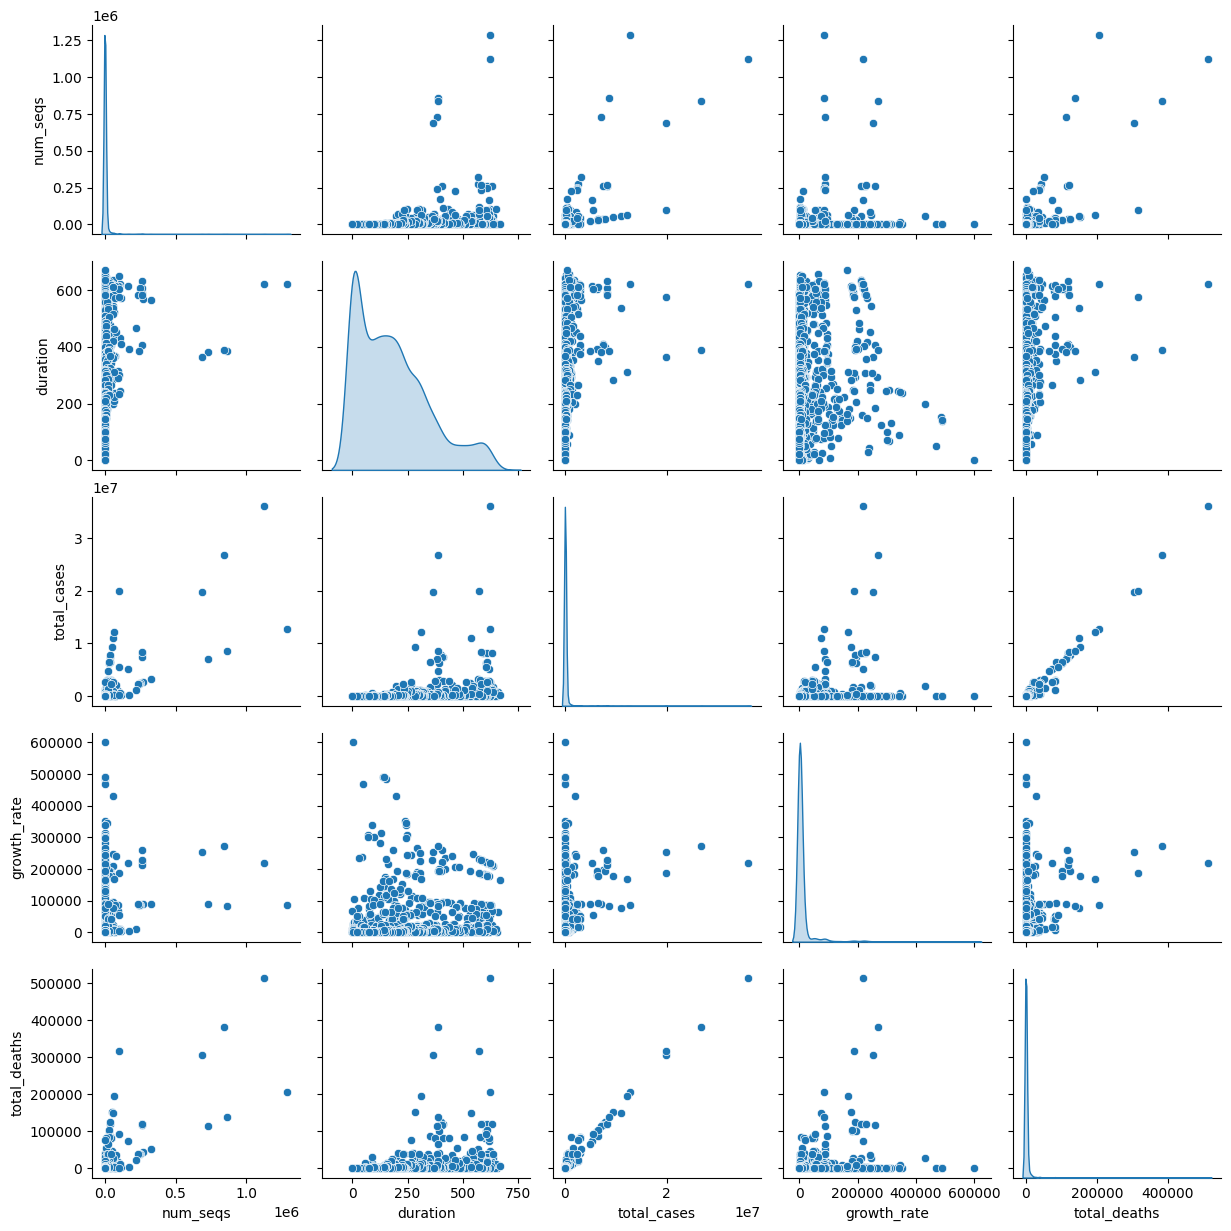

In [11]:
sns.pairplot(df_numeric, diag_kind="kde") # Mostrar distribución de los valores en las variables numéricas

Nos encontramos con una distribución de valores muy sesgada, con valores que se concentran en gran medida en un punto y con una larga cola hacia la derecha. Esto puede ser causado por valores atípicos muy elevados, por lo que lo mejor será realizar una normalización de los datos para que esto no afecte al entrenamiento de nuestro modelo.

## Preprocesamiento del dataset. Transformaciones previas necesarias para la modelación

Primero vamos a tratar los nulos:

In [11]:
X = X.fillna(0)  # Reemplaza valores faltantes
y = y.fillna(0)  

Ahora vamos a normalizar los datos. Para ello, vamos a realizar una transformación logarítmica para reducir la asimetría y estabilizar el modelo.

In [12]:
log_transform_columns = ['num_seqs', 'total_cases', 'growth_rate'] # Variables a normalizar

for col in log_transform_columns:
    X[col] = np.log1p(X[col])  # log(x + 1) para evitar problemas con valores 0

y_transformed = np.log1p(y)  # log(y + 1)

C:\Users\Ismael Perez\AppData\Local\Temp\ipykernel_31284\2230623979.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.log1p(X[col])  # log(x + 1) para evitar problemas con valores 0


En el siguiente paso, vamos a tratar cada variable de entrada de cara a entrenar el modelo, realizando las transformaciones necesarias para las redes neuronales. Según el tipo de variable, vamos a realizar las siguientes transformaciones:
- Numérica: Vamos a escalar los datos numéricos, paso necesario para las redes neuronales para mejorar la convergencia del modelo.
- Categórica: Tenemos que realizar una codificación para transformar las variables nominales a numéricas.
- Booleana: Al igual que con la variable categórica, debemos realizar una conversión para obtener una variable numérica.

In [13]:
numeric_features = ['num_seqs', 'duration', 'total_cases', 'growth_rate']  # Variables numéricas
categorical_features = ['variant']  # Variables categóricas
boolean_features = ['censored']  # Variables booleanas (True/False)

preprocessor = ColumnTransformer(
    transformers=[
        # Escalamiento y log-transform para las variables numéricas
        ("num", StandardScaler(), numeric_features),
        # Codificación One-Hot para las variables categóricas
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        # Conversión de booleanos a 0/1
        ("bool", "passthrough", boolean_features),
    ],
    remainder="drop"  # Ignora columnas no especificadas
)

# Aplicar transformaciones al conjunto de datos
X_processed = preprocessor.fit_transform(X)

## División del dataset en datos de entrenamiento y datos de test 

Para dividir el conjunto de datos en datos de entrenamiento y datos de test, vamos a dedicar el 20% a tests y el resto a entrenamiento, debido a que esta es una distribución común.

Para evaluar el rendimiento del modelo, vamos a utilizar la función de perdida de Mean Squared Error (MSE), puesto que vamos a evaluar el rendimiento de un modelo neuronal de regresión esperando una salida numérica.

In [14]:
# División del conjunto de datos en entrenamiento y test
X_train, X_test, y_train, y_test_scaled = train_test_split(X_processed, y_transformed, test_size=0.2, random_state=42)

Vamos a deshacer la transformación logarítmica para la salida del conjunto de prueba, para que cuando comparemos el resultado, el resultado sea más fácil de leer.

In [13]:
# Transformación logarítmica inversa para el conjunto de test
y_test = np.expm1(y_test_scaled)

NameError: name 'y_test_scaled' is not defined

## Propuesta de arquitectura de red neuronal

Nuestro modelo de redes neuronales va a seguir la siguiente arquitectura:
- Una capa de entrada con una entrada de 62 neuronas
- Dos capas intermedias, con funciones de activación ReLU
- Una capa de salida con activación lineal

In [21]:
# Definir el modelo
model = Sequential([
    Input(shape=(62,)),
    # Primera capa oculta con 64 neuronas y activación ReLU
    Dense(64, activation='relu'),  
    # Segunda capa oculta con 32 neuronas y activación ReLU
    Dense(32, activation='relu'),
    # Capa de salida con activación lineal
    Dense(1, activation='linear')
])

# Compilar el modelo
model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])

In [22]:
#Código de la inspección del modelo de red
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,145 (24.00 KB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 0 (0.00 B)

##  Ajuste de modelo de Regresión RNA

Vamos a entrenar nuestro modelo de regresión basado en redes neuronales:

In [23]:
#Código de ajuste y entrenamiento
history = model.fit(
  X_train, y_train,
  validation_split = 0.2,
  epochs=50,
  verbose=1,
  batch_size=32)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.6667 - mae: 2.6742 - mse: 12.6667 - val_loss: 1.1296 - val_mae: 0.8324 - val_mse: 1.1296
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7892 - mae: 0.6884 - mse: 0.7892 - val_loss: 0.4715 - val_mae: 0.5090 - val_mse: 0.4715
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3979 - mae: 0.4739 - mse: 0.3979 - val_loss: 0.5508 - val_mae: 0.5650 - val_mse: 0.5508
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3625 - mae: 0.4491 - mse: 0.3625 - val_loss: 0.3686 - val_mae: 0.4390 - val_mse: 0.3686
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3024 - mae: 0.4033 - mse: 0.3024 - val_loss: 0.3725 - val_mae: 0.4449 - val_mse: 0.3725
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3019 - mae: 0.4058 - mse: 0.3019 - val_loss: 0.4200 - val_mae: 0.4788 - val_mse: 0.4200
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2797 - mae: 0.3840 - mse: 0.2797 - val_loss: 0.362

## Evaluación de modelo RNA

Para evaluar nuestro modelo, vamos a observar la evolución de la pérdida de entrenamiento y de validación; así como la evolución del MAE y del MSE.

### Visualice el progreso de entrenamiento del modelo y muestre las estadísticas de evaluación para los conjuntos de entrenamiento y validación.  

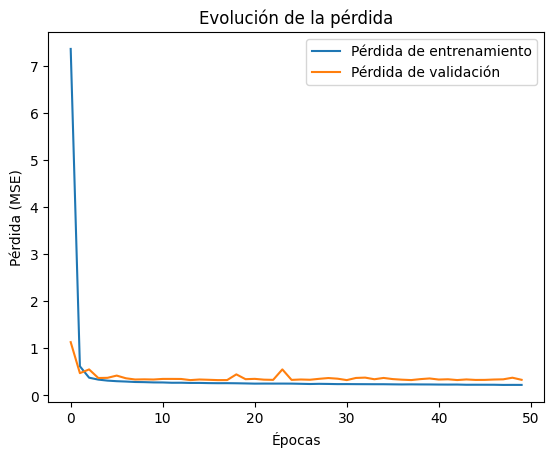

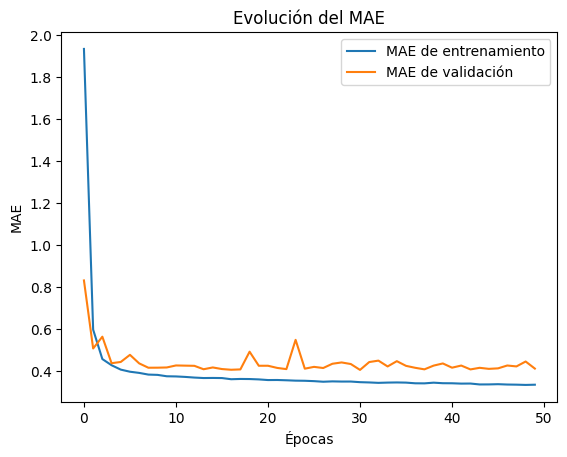

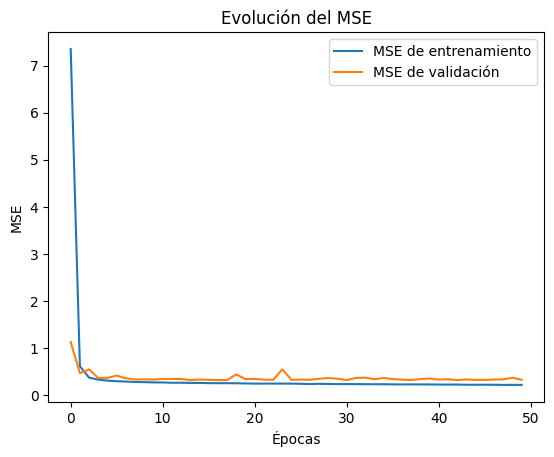

In [24]:
#Código de evaluación de la red propuesta (entrenamiento y validación)

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución de la pérdida')
plt.show()

# Graficar el MAE
plt.plot(history.history['mae'], label='MAE de entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de validación')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.title('Evolución del MAE')
plt.show()

### Evalúe los resultados  para el conjunto de test.

In [25]:
# Predicción del modelo
y_pred_nn_scaled = model.predict(X_test)
y_pred_nn = np.expm1(y_pred_nn_scaled)

# Evaluar en el conjunto de prueba
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"MSE en el conjunto de prueba: {mse_nn}")
print(f"MAE en el conjunto de prueba: {mae_nn}")
print(f"R² en el conjunto de prueba: {r2_nn}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE en el conjunto de prueba: 3928544.25
MAE en el conjunto de prueba: 386.2724914550781
R² en el conjunto de prueba: 0.9279056787490845


Vamos a ver de forma gráfica cómo de cerca se quedan los valores que nuestro modelo ha predecido con respecto a los valores reales.

In [14]:
# Mostrar por gráfica la comparación de los valor de la predicción y los reales
plt.scatter(y_test_scaled, y_pred_nn_scaled)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

NameError: name 'y_test_scaled' is not defined

Como podemos ver, nuestro modelo se ajusta bastante a los valores reales, con la suficiente varianza como para poder descartar el sobre-entrenamiento. Los resultados son favorables.

## Ajuste de modelos de Regresión alternativos

Para comparar nuestro modelo basado en redes neuronales, vamos a construir otro modelo siguiendo la técnica de SVR. Para ello, tenemos que construir y entrenar el modelo:

In [27]:
# Construcción del modelo
svr = SVR()

# Entrenamiento del modelo
svr.fit(X_train, y_train)

C:\Users\Ismael Perez\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [28]:
# Predicción del modelo
y_pred_svr_scaled = svr.predict(X_test)
y_pred_svr = np.expm1(y_pred_svr_scaled)

# Evaluar en el conjunto de prueba
mse_svr = mean_squared_error(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"MSE en el conjunto de prueba: {mse_svr}")
print(f"MAE en el conjunto de prueba: {mae_svr}")
print(f"R² en el conjunto de prueba: {r2_svr}")

MSE en el conjunto de prueba: 12140869.644498639
MAE en el conjunto de prueba: 545.1322106372357
R² en el conjunto de prueba: 0.7771979344954566


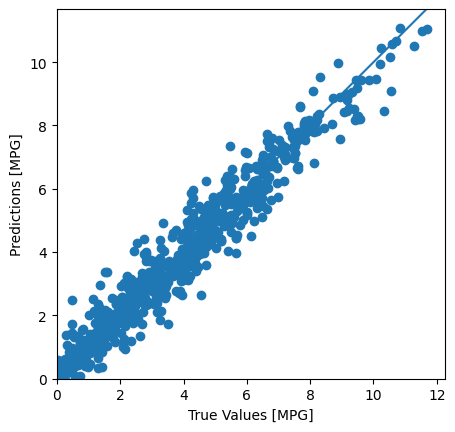

In [29]:
# Mostrar por gráfica la comparación de los valor de la predicción y los reales
plt.scatter(y_test_scaled, y_pred_svr_scaled)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Construya un o dos párrafos con los principales hallazgos. Incluye una explicación de los parámetros que consideres relevantes en cada ejecución.

## Comparación del desempeño de modelos

In [30]:
# Comparación de métricas de desempeño de las dos propuestas en tabla
results = {
    "Modelo": ["SVR", "Red Neuronal", "Diferencia"],
    "MSE": [
        mse_nn,
        mse_svr,
        mse_nn-mse_svr,
    ],
    "MAE": [
        mae_nn,
        mae_svr,
        mae_nn-mae_svr,
    ],
    "R²": [
        r2_nn,
        r2_svr,
        r2_nn-r2_svr,
    ],
}

results_df = pd.DataFrame(results)
print(results_df)

         Modelo           MSE         MAE        R²
0           SVR  3.928544e+06  386.272491  0.927906
1  Red Neuronal  1.214087e+07  545.132211  0.777198
2    Diferencia -8.212325e+06 -158.859719  0.150708


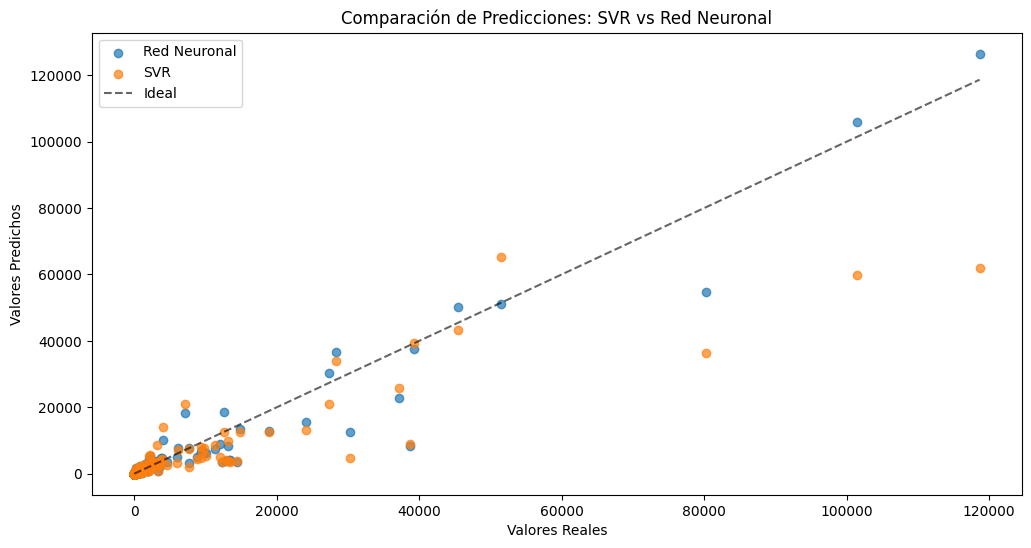

In [31]:
# Comparación de métricas de desempeño de las dos propuestas en gráfica
y_test_flattened = y_test.values.flatten()

plt.figure(figsize=(12, 6))

# Gráfica de predicciones reales vs. predichas
plt.scatter(y_test_flattened, y_pred_nn, label='Red Neuronal', alpha=0.7)
plt.scatter(y_test_flattened, y_pred_svr, label='SVR', alpha=0.7)
plt.plot([min(y_test_flattened), max(y_test_flattened)], [min(y_test_flattened), max(y_test_flattened)], 'k--', label="Ideal", alpha=0.6)
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Comparación de Predicciones: SVR vs Red Neuronal")
plt.legend()
plt.show()

Para valores pequeños, la diferencia entre la predicción de los dos modelos es mínima, teniendo que observar caso a caso qué modelo ha hecho una mejor predicción; aunque para valores altos parece que las redes neuronales obtienen un mejor rendimiento. Sin embargo, la diferencia no es lo suficientemente destacable como para poder dar un veredicto inequívoco. Ambos modelos obtienen un rendimiento satisfactorio.

## Discusión de los resultados obtenidos y argumentos sobre cómo se podrían mejorar de dichos resultados

Como se ha descrito en el apartado anterior, la diferencia entre ambos modelos es mínima. Se puede decir que para valores pequeños, el SVR tiene un mejor rendimiento mientras que para los valores más altos, la red neuronal parece ajustarse más; pero no es una diferencia lo suficientemente significativa como para llegar a una conclusión que no dé lugar a dudas.

Sin embargo, si se tuviera que elegir un modelo, basándonos en las métricas de evaluación, podemos determinar que es la red neuronal la que obtiene un mejor rendimiento, consiguiendo una mejor puntuación en las 3 métricas que hemos adoptado.

Podríamos mejorar nuestro modelo neuronal utilizando diferentes configuraciones en su arquitectura, como cambiar el número de neuronas, incrementar el número de capas intermedias o cambiar las funciones de activación. Para ello podríamos utilizar la técnica de hiper parametrización para probar diferentes configuraciones y comparar sus resultados para obtener la arquitectura que mejor se adapte a nuestro problema.

También podríamos realizar una selección distinta de las variables de entrada que utilizamos del conjunto de datos original. Se podría argumentar que parámetros como el país o la tasa de mortalidad podrían haber sido elegibles para el entrenamiento de nuestro modelo, por lo que también se podría cambiar el preprocesamiento en este ejercicio para mejorar el rendimiento del modelo.